<a href="https://colab.research.google.com/github/xesmaze/cpsc541-fall2024/blob/main/lectures/GLM_LFcomp_ROCcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Do GLM?**
- The primary objective of the GLM is to find a mathematical function that can linearize the response($ \mathbf Y $)

Although, this may be somewhat ambigous, you would be able to do this by hyper-parameter search, just like any other hyper-parameter.

1. **Understand the Distribution Shape:**

  Look at the data's histogram and/or Q-Q plot to get a sense of its shape. For example, if the data is right-skewed, transformations that compress larger values might work, such as a log or square root transformation.

2. **Check if there are any Common Transformations Based on Distribution Properties:**

  Here are some common transformations based on typical distribution shapes:
  * **Logarithmic (log) Transformation**: Effective for right-skewed distributions (e.g., income data, biological measurements).
  * **Square Root Transformation**: Useful for counts or data with moderate right skew.
  * **Inverse Transformation (1/x)**: Often used for highly skewed, decreasing functions.
  * **Power Transformations**: Generalized transformations like the Box-Cox transformation can be effective, which optimizes the power exponent to find the best fit.
  * **Arcsine or Logit Transformation**: Useful for proportions or data bounded between 0 and 1.

3. **Write a custom link function if a common one does not fit**:

  Remember a computer is a glorified programmable calculator. It is easy to write an equation in python code.

  To use a custom link function in a GLM, you can define it manually and pass it to the model.


4. **Try Transformations and Plot**:

  Apply different transformations to the data and check scatter plots, Q-Q plots against normal or uniform distributions. Also check the transformed $\mathbf Y$ versus the predictors($\mathbf X$). If the transformation reduces skewness or the QQ-plot becomes more linear, that transformation is likely effective.

5. **Fit and Compare Models with Different Link Functions**:

  In the case of Generalized Linear Models (GLMs), try different link functions (e.g., identity, log, logit) and assess model fit (e.g., using AIC, AUC-ROC and confusion matrices, residual plots) to see which function best captures the data's linearity, or which function does a better job with classification.

 # **How to create a Custom Link Function?**

 `statsmodels` offers flexibility in specifying or modifying link functions.
  
  * A link function is a transformation that relates the linear predictor (like Xβ) to the mean of the response variable, μ.

  * To define a custom link, you create a **class** inheriting from `statsmodels.genmod.families.links.Link`.
  
  Let's implement some of the core transformations: `__call__`, `inverse`, and `inverse_deriv` and pass it to the GLM model.

In [ ]:
import numpy as np
from statsmodels.genmod.families.links import Link

class CustomLink(Link):
    def __init__(self):
        # Initialize the link with a name (optional)
        self.name = "custom_link"

    def __call__(self, mu):
        # Define the transformation from mu (mean) to linear predictor
        return np.log(mu + 1)  # example: log(mu + 1)

    def inverse(self, lin_pred):
        # Define the inverse transformation from linear predictor to mu
        return np.exp(lin_pred) - 1

    def inverse_deriv(self, lin_pred):
        # Optional: derivative of the inverse transformation for model fit
        return np.exp(lin_pred)

import statsmodels.api as sm

# Assuming you have your response variable y and predictors X
model = sm.GLM(y, X, family=sm.families.Poisson(link=CustomLink()))
results = model.fit()
print(results.summary())

Alternatively, you can go fully manual- and write code to do both transformation, and back-transformation using `scikit-learn`

Below code applies a custom transformation to your target ($y$) based on your custom link, such as $ log(y + 1) $, and then fits the transformed model.

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Example custom transformation
y_transformed = np.log(y + 1)


X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_test, y_test)

However, you will need to reverse the transformation to bring predictions from this model back to the original scale, for interpretation...

In [ ]:
y_pred_transformed = model.predict(X_test)
y_pred = np.exp(y_pred_transformed) - 1  # Inverse of log(y + 1)

Test your custom link’s effectiveness by comparing model Goodness-of-Fit statistics (e.g., AIC, residuals, AUC).

Below is example code to simulate some data classification data and test GLM with various link functions on it

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:989: RuntimeWarning: overflow encountered in exp
  return 1 - np.exp(-np.exp(z))


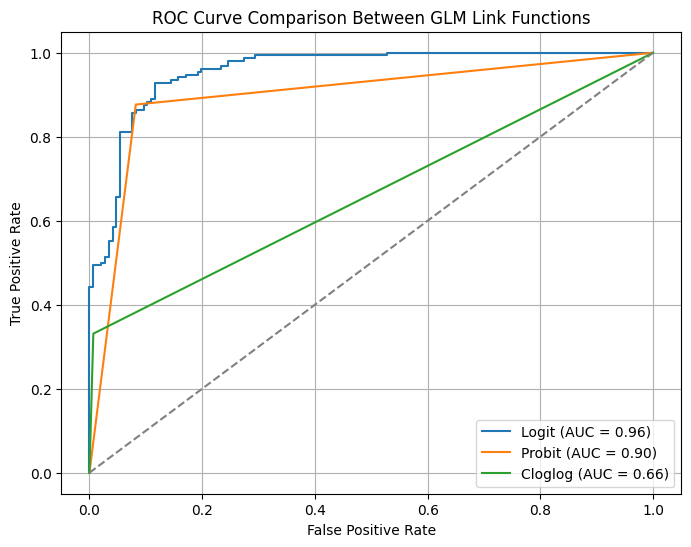

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm

# Step 1: Generate synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=5, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add intercept term for GLM models
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Step 2: Fit GLM models with different link functions
links = {'Logit': sm.families.links.Logit(), 'Probit': sm.families.links.Probit(), 'Cloglog': sm.families.links.CLogLog()}
models = {}
predictions = {}

for name, link in links.items():
    model = sm.GLM(y_train, X_train, family=sm.families.Binomial(link=link)).fit()
    models[name] = model
    predictions[name] = model.predict(X_test)

# Step 3: Calculate ROC curves and AUC for each link function
plt.figure(figsize=(8, 6))

for name, y_pred in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Between GLM Link Functions')
plt.legend()
plt.grid(True)
plt.show()


Let's try other link functions with Poisson link

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


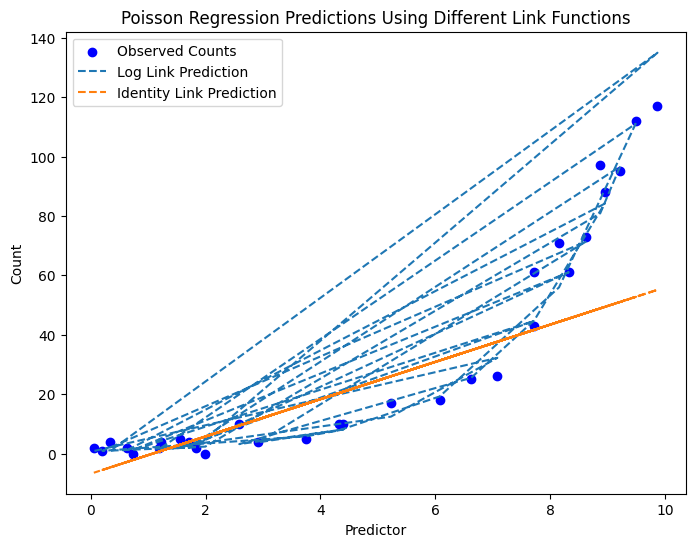

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Step 1: Generate synthetic Poisson data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Predictor variable in a range from 0 to 10
rate = np.exp(0.5 * X.flatten())  # Define rate as an exponential function of X
y = np.random.poisson(lam=rate)  # Poisson-distributed response variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add intercept term for GLM models
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Step 2: Fit Poisson GLM models with log and identity link functions
links = {'Log': sm.families.links.log(), 'Identity': sm.families.links.identity()}
models = {}
predicted_counts = {}

for name, link in links.items():
    # Fit the GLM model with Poisson family
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=link)).fit()
    models[name] = model

    # Predict counts on the test set
    predicted_counts[name] = model.predict(X_test)

# Step 3: Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 1], y_test, color='blue', label='Observed Counts')  # Actual data points

# Plot predictions for each link function
for name, y_pred in predicted_counts.items():
    plt.plot(X_test[:, 1], y_pred, label=f'{name} Link Prediction', linestyle='--')

plt.xlabel('Predictor')
plt.ylabel('Count')
plt.title('Poisson Regression Predictions Using Different Link Functions')
plt.legend()
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Step 1: Generate synthetic Poisson data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Predictor variable in a range from 0 to 10
rate1 = np.exp(0.5 * X.flatten())  # Define rate as an exponential function of X
rate2 = np.exp(0.55 * X.flatten())  # Define rate as an exponential function of X

y1 = np.random.poisson(lam=rate1)  # Poisson-distributed response variable
y2 = np.random.poisson(lam=rate2)  # Poisson-distributed response variable

Y = np.stack((y1, y2),axis=1)

# Split data into training and test sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


# Add intercept term for GLM models
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Step 2: Define multiple link functions
links = {
    'Log': sm.families.links.log(),
    'Identity': sm.families.links.identity(),
 #   'Inverse': sm.families.links.InversePower(),  # Reciprocal link (1 / mu)
}

# Step 3: Fit Poisson GLM models with different link functions and store predictions
models = {}
predicted_counts = {}

for name, link in links.items():
    # Fit the GLM model with Poisson family using the specified link function
    model = sm.GLM(Y_train, X_train, family=sm.families.Poisson(link=link)).fit()
    models[name] = model
    # Predict counts on the test set
    predicted_counts[name] = model.predict(X_test)

# Step 4: Visualize Predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 1], Y_test[:, 0], color='blue', label='Observed Counts')  # Actual data points

# Plot predictions for each link function
for name, y_pred in predicted_counts.items():
    plt.plot(X_test[:, 0], Y_pred, label=f'{name} Link Prediction', linestyle='--')

plt.xlabel('Predictor')
plt.ylabel('Count')
plt.title('Poisson Regression Predictions Using Different Link Functions')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 1], Y_test[:, 1], color='blue', label='Observed Counts')  # Actual data points

# Plot predictions for each link function
for name, y_pred in predicted_counts.items():
    plt.plot(X_test[:, 1], Y_pred, label=f'{name} Link Prediction', linestyle='--')

plt.xlabel('Predictor')
plt.ylabel('Count')
plt.title('Poisson Regression Predictions Using Different Link Functions')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(


AttributeError: module 'statsmodels.api' has no attribute 'GLMM'

Try making colab "Explain error"- see if you can debug this solution.
10 extra credit points if you can get it to work before the lab session this Friday (10/8)